# Advance Lane Finding
This project implements advance Lane finding using OpenCV. Task of lane finding can be divided into following steps:

### Preprocess Images
In order to detect lane lines in camera images, we first need to transform input images to make it easy for Lane detection

##### Camera Caliberation
Before proceeding with distortion correction of input images, we need to calibrate the camera with known pattern image for which we know the distortion e.g. chesssboard images are good candidate for being symmetrical and high contrast images and we know exactly how they should look like without distortion.

##### Distortion Correction
Undistort input images with distortion coefficients and camera matrix obtained by camera calibration step.

##### Color and Gradient Threshold

##### Perspective Transform

### Lane Detection
##### Sliding Window Search
##### Measuring Curvature

### Display Detected Lanes
Finally display lanes detected by overlaying on input images

## Preprocess Images

### Camera Calibration
As a first step in calibrating camera, obtain image points in distorted images by finding internal corners and map them to object points.

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib qt

image_points = [] # 2d points in image fram
obj_points = [] # 3d points in real world

# Internal corner points dimensions in chessboard images
ny, nx = (6, 9)

# create 3d object points as all internal corner points in chesboard
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Read all calibration images and find corners
cal_images = glob.glob('./camera_cal/calibration*.jpg')
for imfile in cal_images:
    image = cv2.imread(imfile)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        image_points.append(corners)
        obj_points.append(objp)
        
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        cv2.imshow('Image with corner detected', image)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

Calibrate camera with image and object points

In [2]:
test_image = cv2.imread('./camera_cal/calibration1.jpg')

# Note that calibrateCamera accepts image_size as (width, height)
ret, cam_mtx, dist_coeff, rvecs, tvecs = \
    cv2.calibrateCamera(obj_points, image_points, test_image.shape[1::-1], None, None)

### Distortion Correction
Undistort images using the camaera matrix and distortion coefficients found by camera calibration above

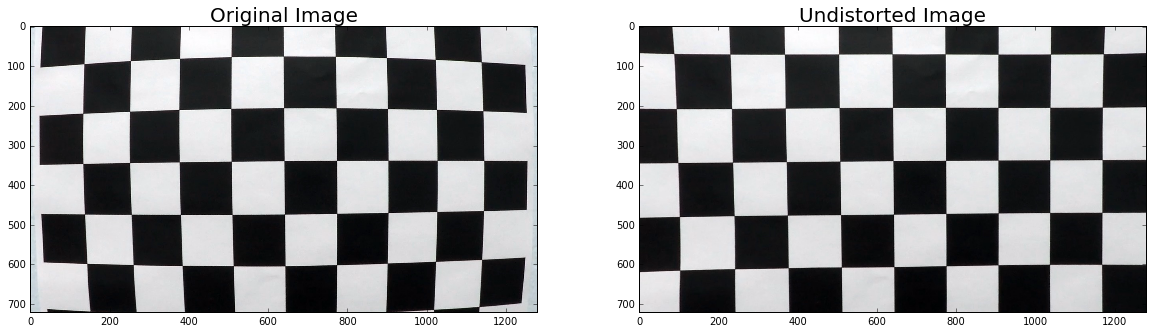

In [3]:
def undistort(image):
    return cv2.undistort(image, cam_mtx, dist_coeff, None, cam_mtx)

undist_image = undistort(test_image)

%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
axs[0].imshow(test_image)
axs[0].set_title('Original Image', fontsize='20')
axs[1].imshow(undist_image)
axs[1].set_title('Undistorted Image', fontsize='20')

### Color and Gradient Threshold


First we will implement gradient thresholding of images. A combination of following thresholds can help better detect lane lines

1. Thresholding gradient along x axis
2. Thresholding gradient along y axis
3. Thresholding magnitute of gradient in both x and y axis
4. Thresholding on gradient orientation

Color threshold is simply thresholding a color channel of image. It may to use different channel for gradient and color thresholding and combine the output of both to get better lane detection.

In [4]:
# paramenter to control smoothness in gradient
SOBEL_KSIZE = 9

# Return sobel value scaled to 0-255
def scale_image(image):
    return np.uint8(255*image/np.max(image))

# Returns binary image with values filtered by threhold range
def get_binary_threshold(input_img, thresh):
    binary_output = np.zeros_like(input_img)
    binary_output[(input_img >= thresh[0]) & (input_img <= thresh[1])] = 1
    return binary_output

# Returns gradient thresholded image from single channel input image 'img'
def get_gradient_threshold(img):
    # Get image gradients with Sobel Operator
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=SOBEL_KSIZE)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=SOBEL_KSIZE)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    
    # Scale gradients
    scaled_sobelx = scale_image(abs_sobelx)
    scaled_sobely = scale_image(abs_sobely)
    scaled_sobelxy = scale_image(abs_sobelxy)
    
    # Direction of gradient
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Get thresholded binary images
    grad_x_thresh = get_binary_threshold(scaled_sobelx, thresh=(20, 100))
    grad_y_thresh = get_binary_threshold(scaled_sobely, thresh=(20, 100))
    grad_xy_thresh = get_binary_threshold(scaled_sobelxy, thresh=(20, 100))
    grad_dir_thresh = get_binary_threshold(scaled_sobelxy, thresh=(np.pi/4, np.pi/2))
    
    # Create a combined binary image
    combined = np.zeros_like(grad_dir_thresh)
    combined[((grad_x_thresh == 1) & (grad_y_thresh == 1)) | \
             ((grad_xy_thresh == 1) & (grad_dir_thresh == 1))] = 1

    return combined
    
def get_color_threshold(img):
    return get_binary_threshold(img, thresh=(170, 255))

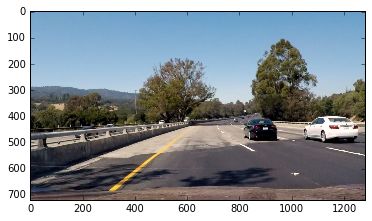

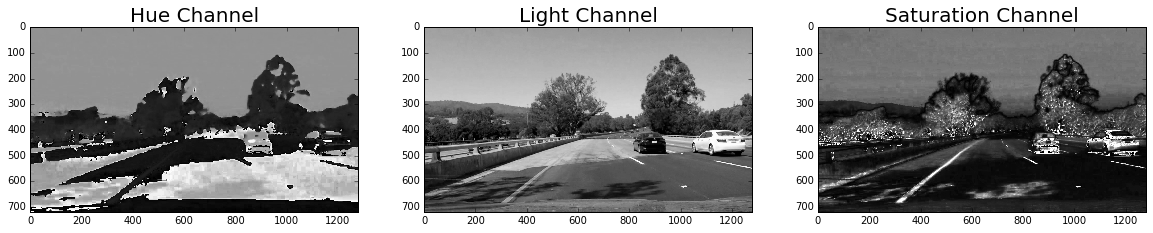

In [73]:
import matplotlib.image as mpimg

test_image = mpimg.imread('./test_images/test4.jpg')
plt.imshow(test_image)

# convert input image to HLS color space
hls = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

# Plot original and threshold image
fig, axs = plt.subplots(ncols=3, figsize=(20, 10))
axs[0].imshow(h_channel, cmap='gray')
axs[0].set_title('Hue Channel', fontsize='20')
axs[1].imshow(l_channel, cmap='gray')
axs[1].set_title('Light Channel', fontsize='20')
axs[2].imshow(s_channel, cmap='gray')
axs[2].set_title('Saturation Channel', fontsize='20')

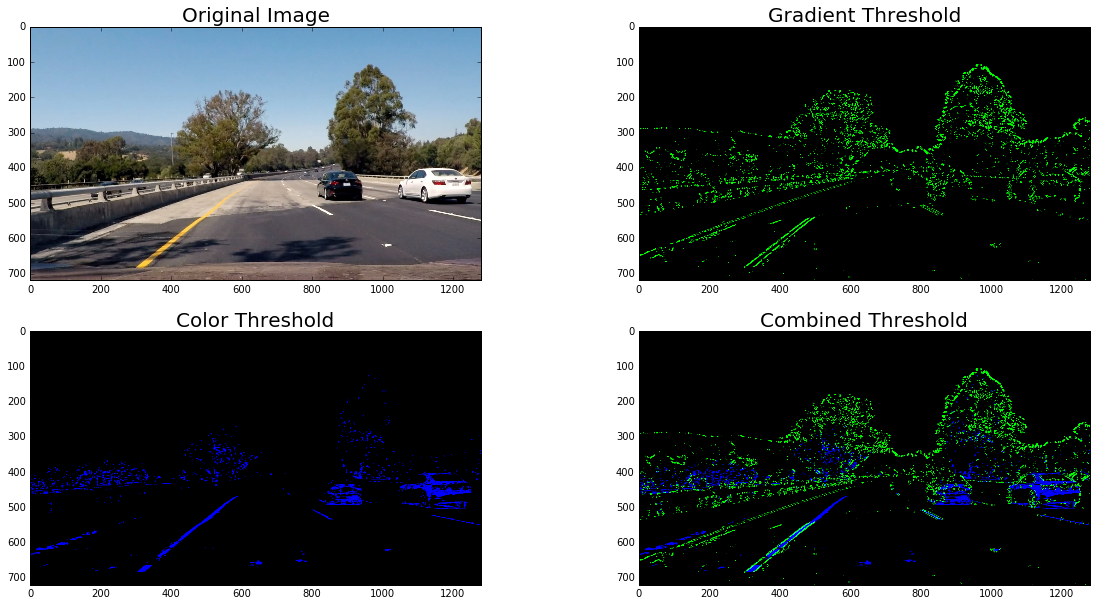

In [74]:
# Get gradient thresholded image
gradient_threshold = get_gradient_threshold(l_channel)
color_threshold = get_color_threshold(s_channel)

# Green channel gradient image
gradient_image = np.dstack((np.zeros_like(gradient_threshold), \
                            gradient_threshold, \
                            np.zeros_like(gradient_threshold)))*255

# Blue channel color image
color_image = np.dstack((np.zeros_like(color_threshold), \
                         np.zeros_like(color_threshold), \
                         color_threshold))*255

# Blue and Green Channel combined image
combined_image = np.dstack((np.zeros_like(color_threshold), \
                            gradient_threshold, \
                            color_threshold))*255

# Plot original and threshold image
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axs[0][0].imshow(test_image)
axs[0][0].set_title('Original Image', fontsize='20')
axs[0][1].imshow(gradient_image)
axs[0][1].set_title('Gradient Threshold', fontsize='20')
axs[1][0].imshow(color_image)
axs[1][0].set_title('Color Threshold', fontsize='20')
axs[1][1].imshow(combined_image)
axs[1][1].set_title('Combined Threshold', fontsize='20')

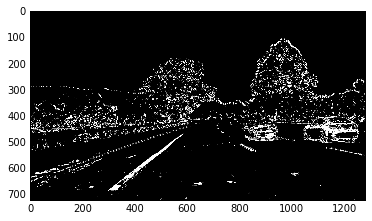

In [75]:
def get_color_gradient_threshold(img):
    # convert input image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Get color and gradient thresholds
    gradient_threshold = get_gradient_threshold(l_channel)
    color_threshold = get_color_threshold(s_channel)
    
    # Combine thresholds
    combined_threshold = np.zeros_like(color_threshold)
    combined_threshold[(gradient_threshold == 1) | (color_threshold == 1)] = 1
    
    return combined_threshold

thresholded_image = get_color_gradient_threshold(test_image)
plt.imshow(thresholded_image, cmap='gray')

### Perspective Transform

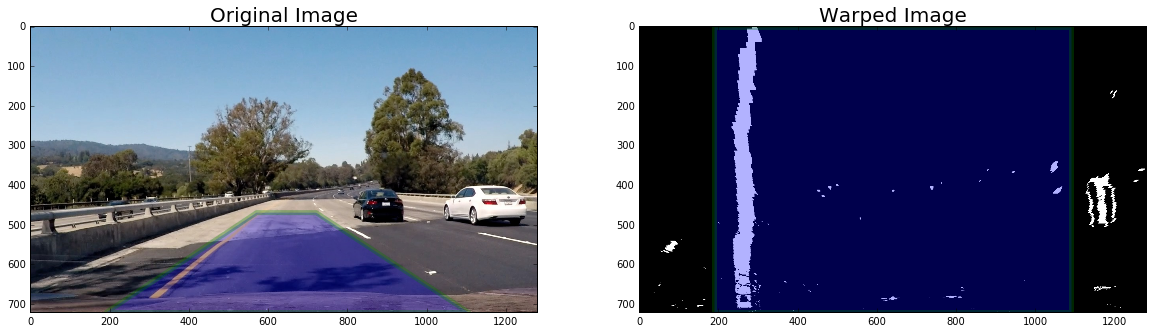

In [76]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def get_warped_image(img, display=False):
    undist = undistort(img)
    thresh_img = get_color_gradient_threshold(undist)

    xsize = img.shape[1]
    ysize = img.shape[0]
    src_pts = np.float32([[570, ysize * 0.65],
                          [xsize-560, ysize * 0.65],
                          [xsize - 175, ysize],
                          [190, ysize]])
    
    offset = 190
    dst_pts = np.float32([[offset, 0],
                          [xsize - offset, 0],
                          [xsize - offset, ysize],
                          [offset, ysize]])
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(thresh_img, M, (xsize, ysize))
    
    if display == True:
        # Plot original and warped image
        fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
        axs[0].imshow(img)
        poly = Polygon(src_pts)
        p = PatchCollection([poly], alpha=0.3, edgecolor='green', linewidth=5)
        axs[0].add_collection(p)
        axs[0].set_title('Original Image', fontsize='20')
        axs[1].imshow(warped, cmap='gray')
        poly = Polygon(dst_pts)
        p = PatchCollection([poly], alpha=0.3, edgecolor='green', linewidth=5)
        axs[1].add_collection(p)
        axs[1].set_title('Warped Image', fontsize='20')

    return warped, M

warped_image, M = get_warped_image(test_image, display=True)

## Lane Detection

### Sliding Window Search

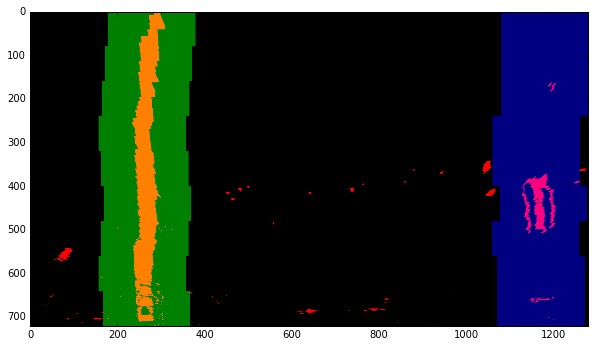

In [77]:
import sys

# Convoluation window size
window_width = 50
window_height = 80
margin = 100 # Search margin around window
min_sum = 50 # minimum sum of pixels in search area to consider a new window

# Find window center convolution in area bounded by box (x1, y1), (x2, y2)
def find_window_center(img, x1=0, y1=0, x2=sys.maxsize, y2=sys.maxsize):
    x1 = int(max(x1, 0))
    x2 = int(min(x2, img.shape[1]))
    y1 = int(max(y1, 0))
    y2 = int(min(y2, img.shape[0]))
    assert(x1 < x2)
    assert(y1 < y2)
 
    window = np.ones(window_width)
    xsum = np.sum(img[y1:y2,x1:x2], axis=0)
    
    # If not enough inputs in search window, return error
    if np.sum(xsum) < min_sum:
        return -1
    
    # NOTE: convolution is maximum at the end of the window, so position of
    # window center is position of max convolution - window_width/2
    return np.argmax(np.convolve(window, xsum)) + x1 - window_width/2

def update_mask(mask, center, y1=0, y2=sys.maxsize):
    y1 = int(max(y1, 0))
    y2 = int(min(y2, mask.shape[0]))
    assert(y1 < y2)
    mask[y1:y2, int(max(center-margin, 0)):int(min(center+margin,mask.shape[1]))] = 1
    
# Returns mask image for selecting left and right lane pixels
def get_lanes_mask(img):
    l_mask = np.zeros_like(img)
    r_mask = np.zeros_like(img)

    # Lane lines are more profounds near the camera, get left and right
    # centers with convolution on last quarter of the image. We will use
    # these centers as starting point for search in each vertical level
    l_center = find_window_center(img, y1=img.shape[0]*3//4, x2=img.shape[1]//2)
    assert(l_center != -1)
    r_center = find_window_center(img, y1=img.shape[0]*3//4, x1=img.shape[1]//2)
    assert(r_center != -1)
    
    # Find windows at each vertical level
    for i in range(0, img.shape[0]//window_height):
        y_max = img.shape[0] - i * window_height
        y_min = y_max - window_height
        
        # Searching at each level is narrowed down with previous centroids +- margin,
        # if new window center could not be found, reuse previous center
        ret = find_window_center(img, x1=l_center-margin, y1=y_min, x2=l_center+margin, y2=y_max)
        if ret != -1:
            l_center = ret
        ret = find_window_center(img, x1=r_center-margin, y1=y_min, x2=r_center+margin, y2=y_max)
        if ret != -1:
            r_center = ret
        
        # Update lane masks with new window centers
        update_mask(l_mask, l_center, y1=y_min, y2=y_max)
        update_mask(r_mask, r_center, y1=y_min, y2=y_max)
        
    return (l_mask, r_mask)

# Let's try plotting windows on a warped image
l_mask, r_mask = get_lanes_mask(warped_image)
src_image = np.dstack((warped_image, np.zeros_like(warped_image), np.zeros_like(warped_image)))*255
window_image = np.dstack((np.zeros_like(l_mask),)*3)
window_image[l_mask == 1] = (0,255,0)
window_image[r_mask == 1] = (0,0,255)
window_image = cv2.addWeighted(src_image, 1, window_image, 0.5, 0.0)
plt.figure(figsize=(10,15))
plt.imshow(window_image)

Now we have the narrowed down range to look for lane lines, now lets fit a polynomial to lane points in the window.

(720, 0)

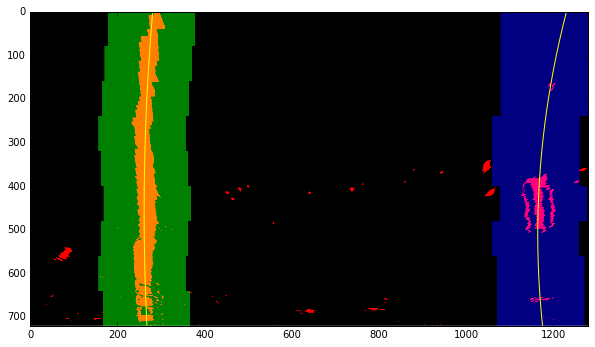

In [78]:
def fit_polynomial(img, mask):
    lane_image = np.bitwise_and(img, mask)
    nonzero = lane_image.nonzero()
    lanex = nonzero[1]
    laney = nonzero[0]
    return np.polyfit(laney, lanex, 2)

left_fit = fit_polynomial(warped_image, l_mask)
right_fit = fit_polynomial(warped_image, r_mask)
ploty = np.linspace(0, warped_image.shape[0]-1, num=warped_image.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.figure(figsize=(10,15))
plt.imshow(window_image)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, warped_image.shape[1])
plt.ylim(warped_image.shape[0], 0)